# Hands-On Machine Learning Project
## Topic 20: Credit Data
### Florian Korn, Vincent Bläske, Dennis Götz

## V. Shortlist Promising Models
1. Train many quick-and-dirty models from different categories (e.g., linear, naive Bayes, kNN, SVM, random forest, neural net, etc.) using standard parameters.
2. Measure and compare their performance:<br>
◦ For each model, use N-fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds.
3. Analyze the most significant variables for each algorithm (e.g., the features with the largest coefficients in a linear regression model).
4. Analyze the types of errors the models make: What data would a human have used to avoid these errors?
5. Perform a quick round of feature selection and engineering.
6. Perform one or two more quick iterations of the five previous steps.
7. Shortlist the top three to five most promising models, preferring models that make different types of errors.

In [173]:
# Import libraries
import pandas as pd
from pandas import get_dummies
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import linear_model
from sklearn import svm
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

# Attributes
attributes = ['Status of existing checking account', 'Duration in month', 'Credit history', 'Purpose', 'Credit amount', 
           'Savings account/bonds', 'Present employment since', 'Installment rate in percentage of disposable income', 
           'Personal status and sex', 'Other debtors / guarantors', 'Present residence since', 'Property',
           'Age in years', 'Other installment plans', 'Housing', 'Number of existing credits at this bank', 'Job',
           'Number of people being liable to provide maintenance for', 'Telephone', 'foreign worker', 'Credit rating']

# Load original dataset DATA-Format
data = pd.read_csv('german.data', sep=' ', header=None)
data.columns = attributes

# Load numerical dataset CSV-Format
data_num = pd.read_csv('german.data-numeric.csv', sep=';', header=None)

# Qualitative attributes
cat_attribs = ['Status of existing checking account', 'Credit history', 'Purpose', 'Savings account/bonds', 
                'Present employment since', 'Personal status and sex', 'Other debtors / guarantors', 'Property',
                'Other installment plans', 'Housing', 'Job', 'Telephone', 'foreign worker', 'Credit rating']

# Numerical attributes
num_attribs = list(set(attributes) - set(cat_attribs))

# Copy the data to a new DataFrame
data_values = data.copy()

# Create dictionary with real values to make the DataFrame readable
cat_dict = {# Attribute 1: (qualitative) Status of existing checking account 
                    'A11' : '... < 0 DM',
                    'A12' : '0 <= ... < 200 DM',
                    'A13' : '... >= 200 DM / salary assignments for at least 1 year',
                    'A14' : 'no checking account',

                    # Attribute 3: (qualitative) Credit history 
                    'A30' : 'no credits taken/ all credits paid back duly',
                    'A31' : 'all credits at this bank paid back duly',
                    'A32' : 'existing credits paid back duly till now',
                    'A33' : 'delay in paying off in the past',
                    'A34' : 'critical account/ other credits existing (not at this bank)',
                    
                    # Attribute 4: (qualitative) Purpose 
                    'A40' : 'car (new)',
                    'A41' : 'car (used)',
                    'A42' : 'furniture/equipment',
                    'A43' : 'radio/television',
                    'A44' : 'domestic appliances',
                    'A45' : 'repairs',
                    'A46' : 'education',
                    'A47' : '(vacation - does not exist?)',
                    'A48' : 'retraining',
                    'A49' : 'business',
                    'A410' : 'others',

                    # Attibute 6: (qualitative) Savings account/bonds 
                    'A61' : '... < 100 DM',
                    'A62' : '100 <= ... < 500 DM',
                    'A63' : '500 <= ... < 1000 DM',
                    'A64' : '... >= 1000 DM',
                    'A65' : 'unknown/ no savings account',

                    # Attribute 7: (qualitative) Present employment since 
                    'A71' : 'unemployed',
                    'A72' : '... < 1 year',
                    'A73' : '1 <= ... < 4 years',
                    'A74' : '4 <= ... < 7 years',
                    'A75' : '... >= 7 years',

                    # Attribute 9: (qualitative) Personal status and sex 
                    'A91' : 'male : divorced/separated',
                    'A92' : 'female : divorced/separated/married',
                    'A93' : 'male : single',
                    'A94' : 'male : married/widowed',
                    'A95' : 'female : single',

                    # Attribute 10: (qualitative) Other debtors / guarantors 
                    'A101' : 'none',
                    'A102' : 'co-applicant',
                    'A103' : 'guarantor',

                    # Attribute 12: (qualitative) Property 
                    'A121' : 'real estate',
                    'A122' : 'if not A121 : building society savings agreement/ life insurance',
                    'A123' : 'if not A121/A122 : car or other, not in attribute 6',
                    'A124' : 'unknown / no property',

                    # Attribute 14: (qualitative) Other installment plans 
                    'A141' : 'bank',
                    'A142' : 'stores',
                    'A143' : 'none',

                    # Attribute 15: (qualitative) Housing 
                    'A151' : 'rent',
                    'A152' : 'own',
                    'A153' : 'for free',

                    # Attribute 17: (qualitative) Job
                    'A171' : 'unemployed/ unskilled - non-resident',
                    'A172' : 'unskilled - resident',
                    'A173' : 'skilled employee / official',
                    'A174' : 'management/ self-employed/ highly qualified employee/ officer',

                    # Attribute 19: (qualitative) Telephone
                    'A191' : 'none',
                    'A192' : 'yes, registered under the customers name',

                    # Attribute 20: (qualitative) foreign worker 
                    'A201' : 'yes',
                    'A202' : 'no',

                    # Target value: (qualitative) Credit rating
                    1 : 'good',
                    2 : 'bad'
                    }

# Apply the dictionary to all categorical attributes of the new DataFrame to get the real values
data_values[cat_attribs] = pd.DataFrame([data_values[attribute].apply(lambda key: cat_dict[key]) for attribute in cat_attribs]).T

In [86]:
attributes = ['Status of existing checking account', 'Duration in month', 'Credit history', 'Purpose', 'Credit amount', 
           'Savings account/bonds', 'Present employment since', 'Installment rate in percentage of disposable income', 
           'Other debtors / guarantors', 'Present residence since', 'Property',
           'Age in years', 'Other installment plans', 'Housing', 'Number of existing credits at this bank', 'Job',
           'Number of people being liable to provide maintenance for', 'Telephone', 'Credit rating']
cat_attribs = ['Status of existing checking account', 'Credit history', 'Purpose', 'Savings account/bonds', 
                'Present employment since', 'Other debtors / guarantors', 'Property',
                'Other installment plans', 'Housing', 'Job', 'Telephone']

In [108]:
# Create a Test Set
data_values_feature_selection = data_values.drop(['Personal status and sex', 'foreign worker'], axis = 1)

onehot_encoder = OneHotEncoder()
data_cat_1hot = onehot_encoder.fit_transform(data_values_feature_selection[cat_attribs])
data_cat_dummies = pd.DataFrame(data_cat_1hot.toarray(),
                                columns=onehot_encoder.get_feature_names_out(), #generate new column names with category as suffix to the attribute
                                index=data_values_feature_selection.index) #keep old indices
data_num = data_values_feature_selection[data_values_feature_selection.columns.difference(cat_attribs)]
data_num = data_num.drop(['Credit rating'], axis = 1)

ordinal_encoder = OrdinalEncoder()
data_y = pd.DataFrame(ordinal_encoder.fit_transform(pd.DataFrame(data_values_feature_selection.iloc[:, -1])).astype(int))
data_y.columns = ['Credit rating']

data_values_encoded = pd.concat([data_num, data_cat_dummies, data_y], axis = 1)

train_set, test_set = train_test_split(data_values_encoded, train_size=0.8, random_state=0, stratify=data_values['Credit rating'])

# Separate features and target values in train and test set
X_train = np.array(train_set.iloc[:, :-1])
y_train = np.array(train_set.iloc[:, -1])
X_test = np.array(test_set.iloc[:, :-1])
y_test = np.array(test_set.iloc[:, -1])

print(f'{X_train.shape = }')
print(f'{X_test.shape = }\n')

X_train.shape = (800, 55)
X_test.shape = (200, 55)



# **Train models with standard parameters**

In [116]:
# Create Pipelines

# Linear Models
## Linear Regression
pipe_reg = Pipeline([('reg', LinearRegression())])

## Ridge Regression
pipe_ridgereg = Pipeline([('scaler', StandardScaler()),
                          ('ridgereg', linear_model.Ridge())])

## Lasso Regression
pipe_lassoreg = Pipeline([('scaler', StandardScaler()),
                          ('lassoreg', linear_model.Lasso())])

## Logistic Regression
pipe_logreg = Pipeline([('scaler', StandardScaler()),
                        ('logreg', LogisticRegression())])

# kNN
pipe_knn = Pipeline([('scaler', StandardScaler()),
                     ('knn', KNeighborsClassifier())])

# naiveBayes
pipe_gaussiannb = Pipeline([('gaussiannb', GaussianNB())])

# Support Vector Machine
pipe_svm = Pipeline([('scaler', StandardScaler()),
                     ('svm', svm.SVC())])

# Random Forest
pipe_rf = Pipeline([('rf', RandomForestClassifier())])

# Decision Tree
pipe_decisiontree = Pipeline([('decisiontree', tree.DecisionTreeClassifier())])

# Neural Network Classifier
pipe_neuralnetwork = Pipeline([('scaler', StandardScaler()),
                               ('neuralnetwork', MLPClassifier())])

# K Fold iterator
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# List of pipelines
pipeline_list = [pipe_reg,
                 pipe_ridgereg,
                 pipe_lassoreg,
                 pipe_logreg,
                 pipe_knn,
                 pipe_gaussiannb,
                 pipe_svm,
                 pipe_rf,
                 pipe_decisiontree,
                 pipe_neuralnetwork]

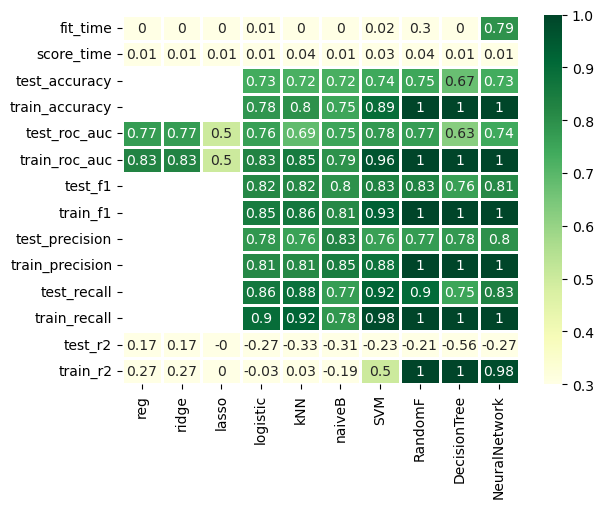

In [188]:
# compute scores of quick and dirty models
scores = pd.concat([pd.DataFrame(pd.DataFrame(cross_validate(pipeline_list[i], 
                                                            X_train,
                                                            y_train,
                                                            scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall', 'r2'],
                                                            cv=kfold,
                                                            n_jobs=-1,
                                                            return_train_score=True)).mean(), columns = [i]) for i in range(len(pipeline_list))], axis = 1)
scores.columns = ['reg', 'ridge', 'lasso', 'logistic', 'kNN', 'naiveB', 'SVM', 'RandomF', 'DecisionTree', 'NeuralNetwork']

# Visualize scores
sns.heatmap(scores, vmin = 0.3, vmax = 1, center = 0.65, linewidth = 1, linecolor = 'white', cmap = 'YlGn', annot = np.round(scores, 2))
plt.show()


Fehlt noch Beschreibung